# Artistic-Style-Pytorch
A Neural Algorithm of Artistic Style with total variation loss in pytorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bruce-willis/Artistic-Style-Pytorch/blob/master/Pytorch_Artistic_Style.ipynb)

Resources:
* [Original paper](https://arxiv.org/pdf/1508.06576.pdf)
* [Pytorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
* [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer) - pay attention to [Total variation loss](https://www.tensorflow.org/tutorials/generative/style_transfer#total_variation_loss) part

First lets download pictures for: 
* style
* content  

You can use your own simply by replacing url in this command

In [0]:
! wget -qO van_gogh_style.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg 
! wget -qO kandinsky_style.jpg http://www.wassilykandinsky.ru/images/works/50.jpg
! wget -qO munch_style.jpg https://upload.wikimedia.org/wikipedia/commons/f/f4/The_Scream.jpg
! wget -qO dali_style.jpg https://5sec.info/files/images/large/salvador-dali-prostranstvo-pamjati.jpg
! wget -qO picasso_style.jpg https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
! wget -qO klimt_style.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/The_Kiss_-_Gustav_Klimt_-_Google_Cultural_Institute.jpg/400px-The_Kiss_-_Gustav_Klimt_-_Google_Cultural_Institute.jpg

In [0]:
! wget -qO palace_content.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Winter_Palace_Panorama_3.jpg/1200px-Winter_Palace_Panorama_3.jpg
! wget -qO kapella_content.jpg https://www.spb-guide.ru/img/5286/50498big.jpg
! wget -qO pishki_content.jpg https://gcdn.tomesto.ru/img/place/000/001/513/kafe-pyshechnaya-na-bolshoy-konyushennoy-ulitse_5dfb4_logo-14256.jpg
! wget -qO mihail_content.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/RUS-2016-Aerial-SPB-St_Michael%27s_Castle.jpg/640px-RUS-2016-Aerial-SPB-St_Michael%27s_Castle.jpg

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import copy

import numpy as np
from tqdm.autonotebook import tqdm, trange

from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.distributions import Normal
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now you can choose any pretrained model

In [6]:
model = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Some helper functions for working with images

In [0]:
imsize = 512 if torch.cuda.is_available() else 128

# scale imported image and transform it into a torch tensor
image_to_tensor = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])


def open_image(path):
    image = Image.open(path)
    # fake batch dimension required to fit network's input dimensions
    tensor = image_to_tensor(image).unsqueeze(0)
    return tensor.to(device)


tensor_to_image = transforms.ToPILImage()


def plot_image(tensor, title=None):
    # clone the tensor to not do changes on it and remove the fake batch dimension
    tensor = tensor.cpu().clone().squeeze(0) 
    image = tensor_to_image(tensor)
    plt.imshow(image)
    plt.axis(False)
    if title is not None:
        plt.title(title)
    plt.tight_layout()

Three kinds of loss:  
* `ContentLoss` - for saving original image content
* `StyleLoss` - for style transfering
* `TotalVariationRegularizationLoss` - to deal with high frequency artifacts (read more [here](https://www.tensorflow.org/tutorials/generative/style_transfer#total_variation_loss))

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target, content_weight):
        super().__init__()
        # 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
        self.content_weight = content_weight

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        self.loss *= self.content_weight
        return input

In [0]:
def gram_matrix(input):
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a feature map (N=c*d)
    a, b, c, d = input.size()

    features = input.view(a * b, c * d)

    # compute the gram product and 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return features @ features.t() / (a * b * c * d)


class StyleLoss(nn.Module):
    def __init__(self, target, style_weight):
        super().__init__()
        self.target_gram = gram_matrix(target).detach()
        self.style_weight = style_weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target_gram)
        self.loss *= self.style_weight
        return input

In [0]:
class TotalVariationRegularizationLoss(nn.Module):
    def __init__(self, total_variation_weight):
        super().__init__()
        self.total_variation_weight = total_variation_weight

    def forward(self, input):
        self.loss =  torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
        self.loss *= self.total_variation_weight
        return input

Normalization layer

In [0]:
# mean and std from images in train set of original vgg network
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean=None, std=None):
        super(Normalization, self).__init__()
        if mean is None:
            mean = vgg_normalization_mean
        if std is None:
            std = vgg_normalization_std
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.as_tensor(mean).view(-1, 1, 1)
        self.std = torch.as_tensor(std).view(-1, 1, 1)

    def forward(self, image):
        """ normalize """
        return (image - self.mean) / self.std

Lets add losses directly inside model, to calulcate error for one `forward` pass

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,
                               style_img, content_img,
                               style_weight, content_weight, total_variation_weight,
                               content_layers=None,
                               style_layers=None):
    if not style_layers:
        style_layers = style_layers_default
    if not content_layers:
        content_layers = content_layers_default

    cnn = copy.deepcopy(cnn)

    content_losses = []
    style_losses = []
    variation_loss = TotalVariationRegularizationLoss(total_variation_weight)
    
    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(variation_loss, Normalization().to(device))

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target = model(style_img).detach()
            style_loss = StyleLoss(target, style_weight)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    # trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses, variation_loss

In [0]:
def run_style_transfer(cnn, 
                       content_img_path, style_img_path, 
                       input_img_type='same', num_steps=900,
                       style_weight=1e9, content_weight=1e-2, total_variation_weight=1e-3):    
    content_img  = open_image(content_img_path)
    style_img  = open_image(style_img_path)

    plt.figure(figsize=(18, 10))
    plt.subplot(1, 3, 1)
    plot_image(content_img, title='Content Image')
    plt.subplot(1, 3, 2)
    plot_image(style_img, title='Style Image')

    if input_img_type == 'same':
        input_img = content_img.clone()
    elif input_img_type == 'random':
        input_img = torch.randn(content_img.data.size(), device=device)
    else:
        raise NotImplementedError(f"Unsupported input image type {input_img_type}")

    model, style_losses, content_losses, variation_loss = get_style_model_and_losses(cnn, style_img, content_img, 
                                                                                     style_weight, content_weight, total_variation_weight)
    optimizer = optim.Adam([input_img.requires_grad_()])

    for i in trange(num_steps):
        # correct the values of updated input image
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)
        variation_score = variation_loss.loss

        loss = style_score + content_score + variation_score 
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f'\r{i}: Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f} Variation Loss: {variation_score.item():4f}', end='')

    input_img.data.clamp_(0, 1)

    plt.subplot(1, 3, 3)
    plot_image(input_img, title='Output Image')

850: Style Loss : 210373.593750 Content Loss: 0.154602 Variation Loss: 77.927345


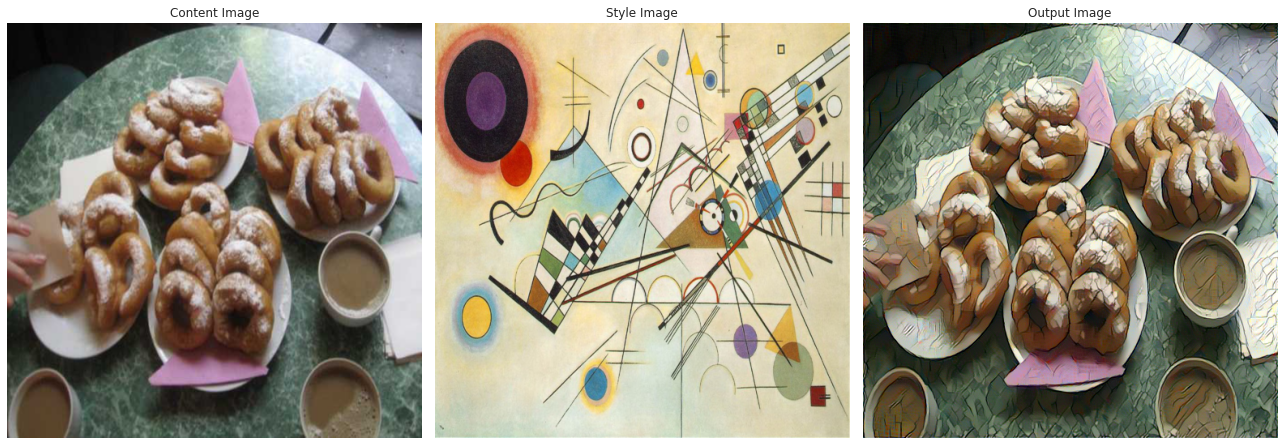

In [14]:
run_style_transfer(model, content_img_path="pishki_content.jpg", style_img_path="kandinsky_style.jpg")

850: Style Loss : 11934.216797 Content Loss: 0.068236 Variation Loss: 47.768986


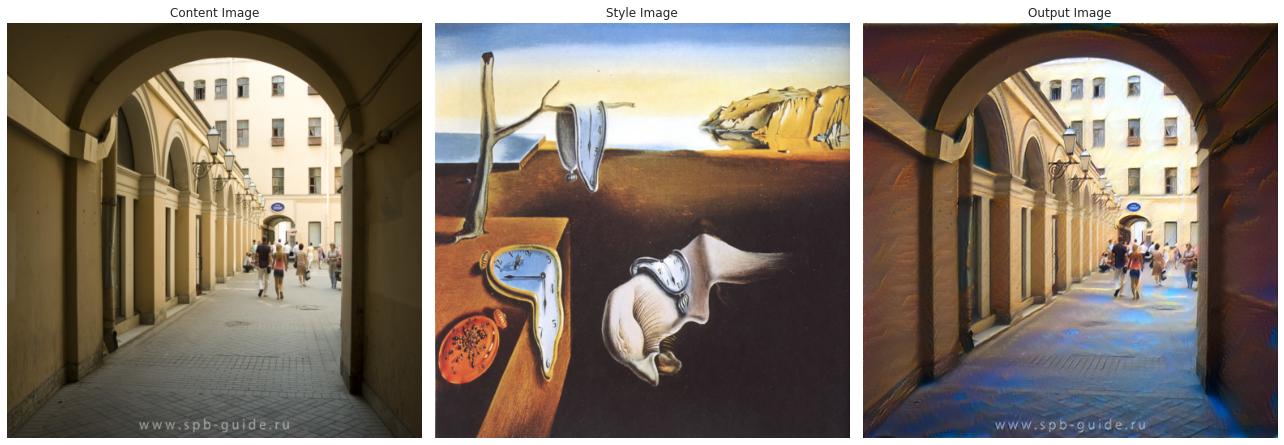

In [15]:
run_style_transfer(model, content_img_path="kapella_content.jpg", style_img_path="dali_style.jpg")

850: Style Loss : 38448.601562 Content Loss: 0.184758 Variation Loss: 95.676018


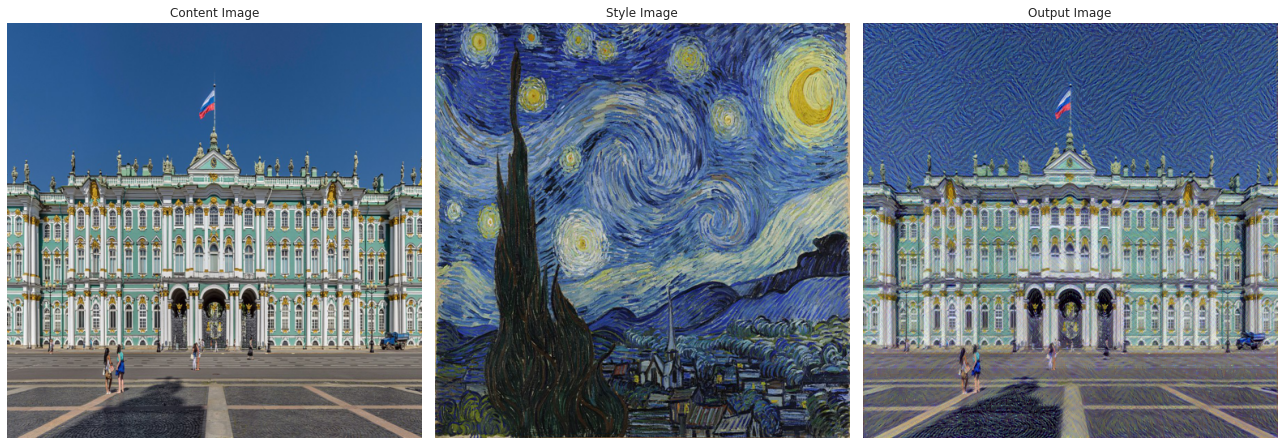

In [16]:
run_style_transfer(model, content_img_path="palace_content.jpg", style_img_path="van_gogh_style.jpg")

850: Style Loss : 196963.609375 Content Loss: 0.175341 Variation Loss: 70.593422


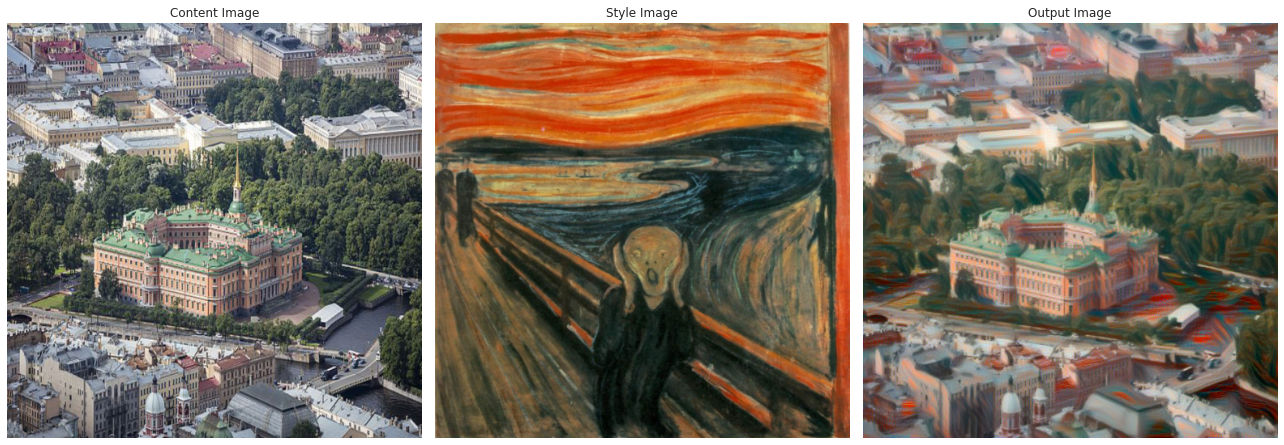

In [17]:
run_style_transfer(model, content_img_path="mihail_content.jpg", style_img_path="munch_style.jpg")